In [1]:
import unidecode
import os
from pathlib import Path

TEST DES 3 METHODES 

In [20]:
import pdfplumber
import re
import os
import glob
import pandas as pd
import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity



In [21]:
# ==========================================
# 1. VOTRE CLASSE DE PARSING (Optimisée)
# ==========================================
class SmartCVParser:
    def __init__(self):
        self.KEYWORDS = {
            "EXPERIENCE": ["experience", "expériences", "parcours", "history", "employment", "work", "postes", "carrière"],
            "FORMATION": ["formation", "education", "diplomes", "études", "cursus", "academic"],
            "COMPETENCES": ["competences", "skills", "outils", "langues", "logiciels", "atouts", "technologies", "stack"],
            "PROFIL": ["profil", "profile", "résumé", "summary", "about", "a propos"]
        }

    def _clean_line(self, text):
        if not text: return ""
        return unidecode.unidecode(text).lower().strip()

    def _detect_section(self, line):
        clean = self._clean_line(line)
        if len(clean) < 50:
            for section, triggers in self.KEYWORDS.items():
                if any(trigger in clean for trigger in triggers):
                    return section
        return None

    def segmenter_texte(self, raw_text):
        data = {k: [] for k in self.KEYWORDS.keys()}
        data["AUTRE"] = []
        current_section = "AUTRE"
        for line in raw_text.split('\n'):
            line = line.strip()
            if not line: continue
            new_section = self._detect_section(line)
            if new_section:
                current_section = new_section
                continue
            data[current_section].append(line)
        return {k: " ".join(v) for k, v in data.items()}

    def parse_pdf(self, pdf_path):
        try:
            text_linear = ""
            text_columns = ""
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    # 1. Lecture LINEAIRE (Toujours sûre)
                    text_linear += (page.extract_text() or "") + "\n"
                    
                    # 2. Lecture COLONNES (Avec sécurité anti-crash)
                    width = page.width
                    height = page.height
                    
                    # --- CORRECTION DU BUG ---
                    # On s'assure que la boîte de découpe ne dépasse jamais les bords réels
                    # On prend le minimum entre la valeur calculée et la largeur réelle
                    x_split = min(width * 0.35, width) 
                    
                    # Définition sécurisée des boîtes
                    # (x0, top, x1, bottom)
                    bbox_left = (0, 0, x_split, height)
                    bbox_right = (x_split, 0, width, height)
                    
                    try:
                        # On tente le crop sécurisé
                        left_crop = page.crop(bbox_left, strict=False) # strict=False aide parfois
                        right_crop = page.crop(bbox_right, strict=False)
                        
                        left_text = left_crop.extract_text() or ""
                        right_text = right_crop.extract_text() or ""
                        text_columns += left_text + "\n" + right_text + "\n"
                        
                    except ValueError:
                        # Si le crop échoue malgré tout (PDF malformé), on abandonne la colonne
                        # et on se rabat sur le texte linéaire pour cette page
                        text_columns += (page.extract_text() or "") + "\n"

            # Le reste ne change pas
            struct_linear = self.segmenter_texte(text_linear)
            struct_columns = self.segmenter_texte(text_columns)
            
            # Comparaison
            if len(struct_columns.get('EXPERIENCE', '')) > len(struct_linear.get('EXPERIENCE', '')) * 1.2:
                return struct_columns, text_columns
            else:
                return struct_linear, text_linear
                
        except Exception as e:
            print(f"❌ Erreur critique sur {os.path.basename(pdf_path)}: {e}")
            return None, None

In [ ]:
# ==========================================
# 2. FONCTIONS D'EMBEDDING (Les 3 Méthodes)
# ==========================================

def get_embedding_method_1_raw(texte_entier, model):
    """Méthode 1 : Tout le CV en un bloc (Risque de dilution)"""
    # On coupe à 1500 caractères pour simuler la limite du modèle si besoin
    return model.encode(texte_entier[:2000])

def get_embedding_method_2_weighted(data_dict, model):
    """Méthode 2 : Moyenne Pondérée des blocs"""
    poids = {
        "COMPETENCES": 0.5, # Priorité max
        "EXPERIENCE": 0.3,  # Contexte
        "FORMATION": 0.2,   # Bonus
        "PROFIL": 0.1       # Faible
        # "AUTRE" est ignoré (poids 0)
    }
    
    vecteurs = []
    poids_sum = 0
    
    for section, weight in poids.items():
        texte = data_dict.get(section, "").strip()
        if texte:
            emb = model.encode(texte)
            vecteurs.append(emb * weight)
            poids_sum += weight
    
    if not vecteurs: return np.zeros(768) # Sécurité
    
    # Somme des vecteurs pondérés / Somme des poids
    vec_final = np.sum(vecteurs, axis=0) / poids_sum
    return vec_final

def get_embedding_method_3_concat(data_dict, model):
    """Méthode 3 : Concaténation Intelligente (Résumé Synthétique)"""
    # On prend les morceaux, on les tronque et on les met dans le bon ordre
    comps = data_dict.get("COMPETENCES", "")[:800] # On garde bcp de skills
    exp = data_dict.get("EXPERIENCE", "")[:800]    # Le début des exp
    form = data_dict.get("FORMATION", "")[:300]    # Juste le diplôme
    
    # On construit une phrase optimisée pour le transformer
    texte_clean = (f"Candidat avec compétences techniques : {comps}. "
                   f"Expérience professionnelle : {exp}. "
                   f"Formation académique : {form}.")
    
    return model.encode(texte_clean)

In [27]:
# ==========================================
# 3. EXÉCUTION DU TEST
# ==========================================

# A. Chargement du modèle
print("⏳ Chargement du modèle...")
model = SentenceTransformer('all-mpnet-base-v2') 

⏳ Chargement du modèle...


In [29]:


# B. Vos Offres 
def lire_offres_depuis_dossier(dossier_path):
    """
    Lit tous les PDF d'un dossier et retourne deux listes :
    1. Les textes nettoyés des offres
    2. Les noms des fichiers (pour l'affichage)
    """
    textes = []
    noms = []
    
    # On cherche tous les PDF
    chemin_recherche = os.path.join(dossier_path, "*.pdf")
    fichiers = glob.glob(chemin_recherche)
    
    print(f"📂 Lecture du dossier offres : {dossier_path}")
    print(f"   -> {len(fichiers)} offres trouvées.")

    for fichier in fichiers:
        nom_fichier = os.path.basename(fichier)
        texte_complet = ""
        
        try:
            with pdfplumber.open(fichier) as pdf:
                for page in pdf.pages:
                    # Extraction simple (on suppose que l'offre est lisible linéairement)
                    texte_page = page.extract_text() or ""
                    texte_complet += texte_page + " "
            
            # Nettoyage basique (on enlève les retours à la ligne excessifs)
            texte_clean = " ".join(texte_complet.split())
            
            if texte_clean:
                textes.append(texte_clean)
                noms.append(nom_fichier)
                print(f"   ✅ Offre chargée : {nom_fichier}")
            else:
                print(f"   ⚠️ Offre vide (ignorée) : {nom_fichier}")
                
        except Exception as e:
            print(f"   ❌ Erreur sur l'offre {nom_fichier} : {e}")

    return textes, noms

# --- UTILISATION DANS VOTRE SCRIPT ---

# B. Chargement des Offres (DYNAMIQUE)
dossier_offres = "/Users/valentine/Desktop/projet stat/env_cv/offres"

# Appel de la fonction
textes_offres, noms_offres = lire_offres_depuis_dossier(dossier_offres)

if len(textes_offres) == 0:
    print("STOP : Aucune offre trouvée dans le dossier !")
    exit() # On arrête si pas d'offres

# Calcul des embeddings des offres
# On utilise la méthode simple (tout le texte) car une offre est un bloc cohérent
print("⏳ Calcul des embeddings des offres...")
emb_offres = model.encode(textes_offres)


# C. Chargement des CVs
parser = SmartCVParser()
dossier_cv = "/Users/valentine/Desktop/projet stat/env_cv/cv" # <--- VOTRE CHEMIN
pdf_files = glob.glob(os.path.join(dossier_cv, "*.pdf"))

# Listes pour stocker les résultats
noms_cv = []
vecs_m1 = [] # Raw
vecs_m2 = [] # Weighted
vecs_m3 = [] # Concat

print(f"\nTraitement de {len(pdf_files)} CVs...")

for pdf_path in pdf_files:
    nom = os.path.basename(pdf_path)
    data_dict, raw_text = parser.parse_pdf(pdf_path)
    
    if data_dict:
        noms_cv.append(nom)
        
        # --- CALCUL DES 3 VARIANTES ---
        v1 = get_embedding_method_1_raw(raw_text, model)
        v2 = get_embedding_method_2_weighted(data_dict, model)
        v3 = get_embedding_method_3_concat(data_dict, model)
        
        vecs_m1.append(v1)
        vecs_m2.append(v2)
        vecs_m3.append(v3)
        print(f"✅ {nom} traité.")

#

📂 Lecture du dossier offres : /Users/valentine/Desktop/projet stat/env_cv/offres
   -> 4 offres trouvées.
   ✅ Offre chargée : offre-vendeur.pdf
   ✅ Offre chargée : offre-boucher.pdf
   ✅ Offre chargée : Offre-barman.pdf
   ✅ Offre chargée : offre-patissier.pdf
⏳ Calcul des embeddings des offres...

Traitement de 4 CVs...
✅ CV-barman.pdf traité.
✅ CV-boucher.pdf traité.
✅ CV-vendeur.pdf traité.
✅ CV-patissier.pdf traité.


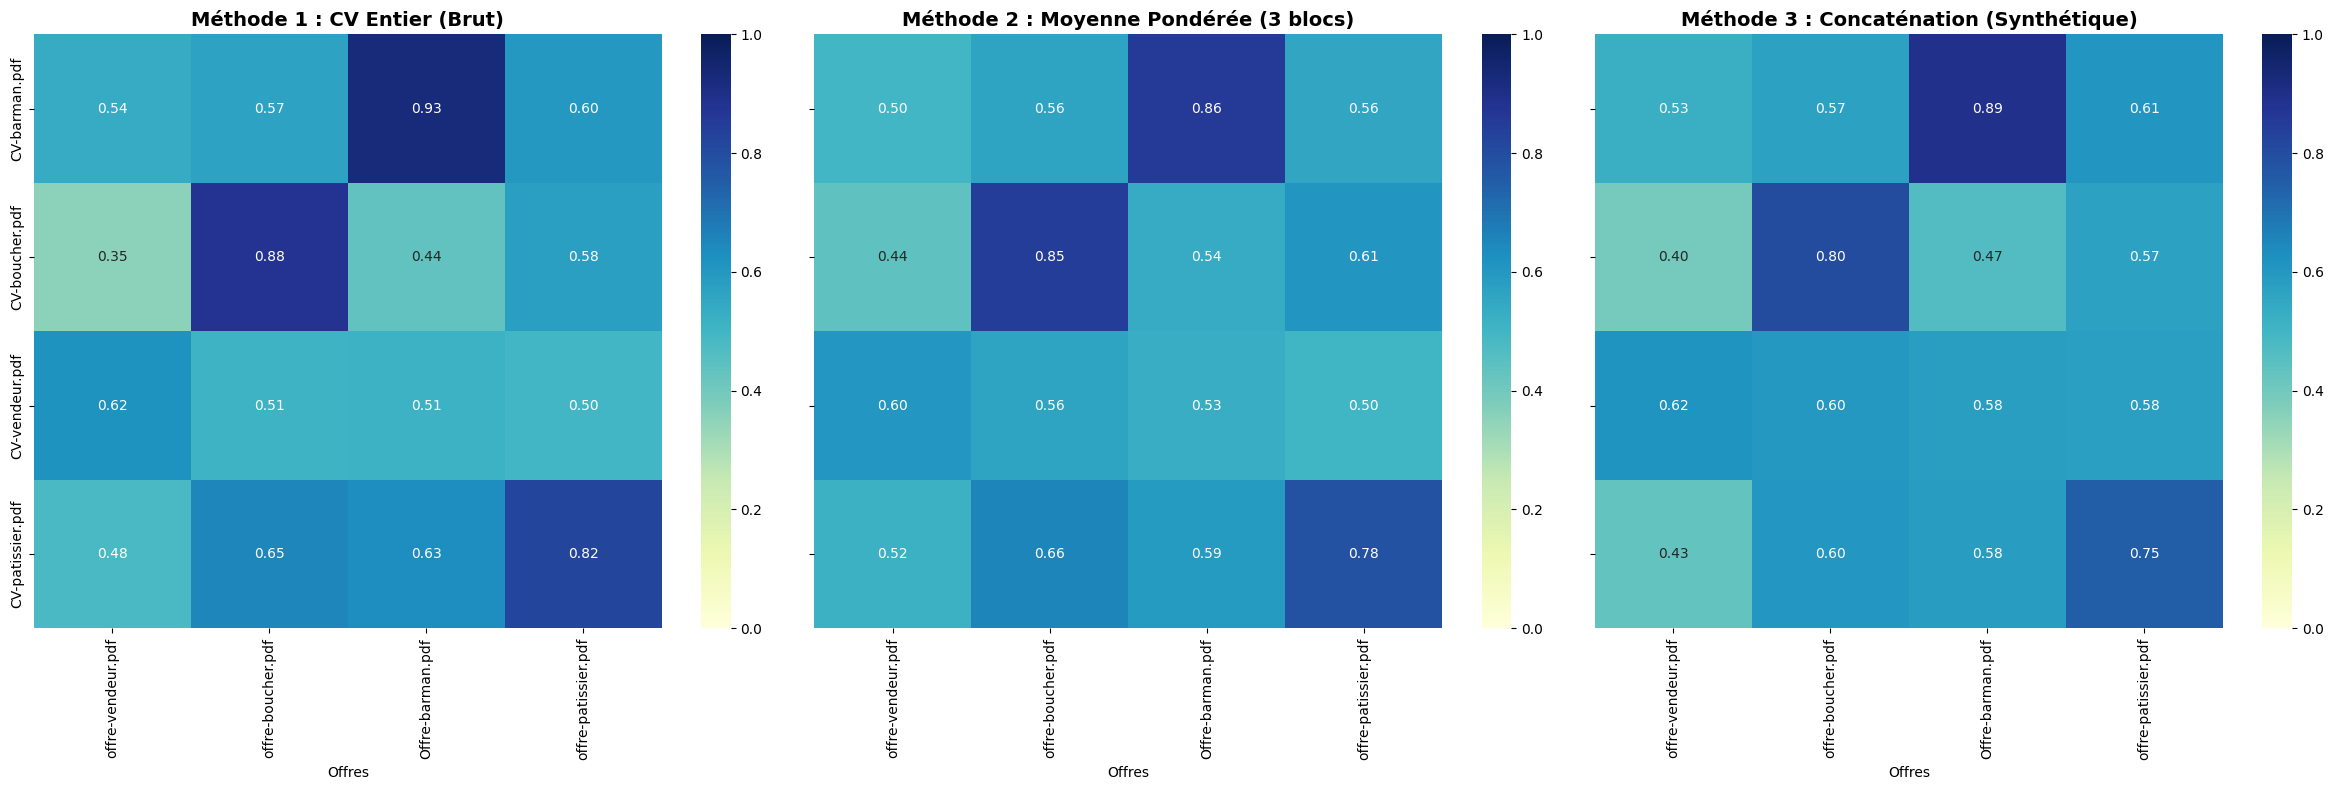

In [30]:
 # ==========================================
# 4. VISUALISATION (3 HEATMAPS)
# ==========================================

# Fonction utilitaire pour afficher
def plot_heatmap(vectors_cv, vectors_offres, title, ax):
    sim_matrix = cosine_similarity(vectors_cv, vectors_offres)
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="YlGnBu", 
                xticklabels=noms_offres, yticklabels=noms_cv, ax=ax, vmin=0, vmax=1)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Offres")

if len(noms_cv) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Plot 1 : Brut
    plot_heatmap(vecs_m1, emb_offres, "Méthode 1 : CV Entier (Brut)", axes[0])

    # Plot 2 : Moyenne Pondérée
    plot_heatmap(vecs_m2, emb_offres, "Méthode 2 : Moyenne Pondérée (3 blocs)", axes[1])

    # Plot 3 : Concaténation
    plot_heatmap(vecs_m3, emb_offres, "Méthode 3 : Concaténation (Synthétique)", axes[2])

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucun CV trouvé ou erreur de lecture.")

In [31]:
# ==========================================
# 5. ANALYSE FINE : QUEL EST LE GAIN RÉEL ?
# ==========================================
import pandas as pd

# On recalcul les matrices de similarité pour l'analyse chiffrée
sim_m1 = cosine_similarity(vecs_m1, emb_offres) # Brut
sim_m3 = cosine_similarity(vecs_m3, emb_offres) # Optimisé

print("\n📊 ANALYSE DES GAINS (Méthode 3 vs Méthode 1)")
print("On regarde si le nettoyage a aidé les 'vrais' matchs.\n")

# On parcourt chaque CV pour voir son meilleur match
for i, nom_cv in enumerate(noms_cv):
    # 1. Quel était le meilleur score avec la méthode "Brut" ?
    score_brut = sim_m1[i].max()
    idx_best = sim_m1[i].argmax()
    offre_best = noms_offres[idx_best]
    
    # 2. Quel est le score pour cette MÊME offre avec la méthode "Optimisée" ?
    score_opti = sim_m3[i][idx_best]
    
    # 3. Calcul du gain
    gain = score_opti - score_brut
    
    # Affichage
    symbole = "✅" if gain > 0 else "🔻"
    if gain > 0.05: symbole = "🚀" # Gros gain
    
    print(f"📄 {nom_cv} -> 🏆 {offre_best}")
    print(f"   Score Brut: {score_brut:.3f} | Score Opti: {score_opti:.3f} | Gain: {symbole} {gain:+.3f}")
    print("-" * 40)


📊 ANALYSE DES GAINS (Méthode 3 vs Méthode 1)
On regarde si le nettoyage a aidé les 'vrais' matchs.

📄 CV-barman.pdf -> 🏆 Offre-barman.pdf
   Score Brut: 0.928 | Score Opti: 0.893 | Gain: 🔻 -0.035
----------------------------------------
📄 CV-boucher.pdf -> 🏆 offre-boucher.pdf
   Score Brut: 0.878 | Score Opti: 0.804 | Gain: 🔻 -0.074
----------------------------------------
📄 CV-vendeur.pdf -> 🏆 offre-vendeur.pdf
   Score Brut: 0.618 | Score Opti: 0.617 | Gain: 🔻 -0.001
----------------------------------------
📄 CV-patissier.pdf -> 🏆 offre-patissier.pdf
   Score Brut: 0.820 | Score Opti: 0.748 | Gain: 🔻 -0.072
----------------------------------------


In [33]:
def get_embedding_method_3_concat(data_dict, model, debug=False):
    """
    Méthode 3 : Concaténation (Synthétique) avec option d'affichage
    """
    # 1. On récupère et nettoie les morceaux
    comps = data_dict.get("COMPETENCES", "").strip()[:800] 
    exp = data_dict.get("EXPERIENCE", "").strip()[:800]    
    form = data_dict.get("FORMATION", "").strip()[:300]    
    
    # 2. On construit le "Super Texte" (C'est ICI que la concaténation se fait)
    texte_clean = (f"Candidat avec compétences techniques : {comps}. "
                   f"Expérience professionnelle : {exp}. "
                   f"Formation académique : {form}.")
    
    # 3. VISUALISATION (Si debug est True, on affiche le résultat)
    if debug:
        print("\n" + "="*50)
        print("👀 [CE QUE VOIT L'IA (MÉTHODE 3)]")
        print("="*50)
        print(texte_clean)
        print("="*50 + "\n")
    
    # 4. Encodage
    return model.encode(texte_clean)
print(f"\nTraitement de {len(pdf_files)} CVs détectés...\n")

for i, pdf_path in enumerate(pdf_files):
    nom = os.path.basename(pdf_path)
    
    if not os.path.exists(pdf_path):
        continue

    data_dict, raw_text = parser.parse_pdf(pdf_path)
    
    if data_dict:
        noms_cv.append(nom)
        
        # --- CALCUL DES 3 VARIANTES ---
        v1 = get_embedding_method_1_raw(raw_text, model)
        v2 = get_embedding_method_2_weighted(data_dict, model)
        
        # ICI : On active le debug seulement pour le premier fichier (i == 0)
        v3 = get_embedding_method_3_concat(data_dict, model, debug=(i==0))
        
        vecs_m1.append(v1)
        vecs_m2.append(v2)
        vecs_m3.append(v3)
        print(f"✅ {nom} traité.")


Traitement de 4 CVs détectés...


👀 [CE QUE VOIT L'IA (MÉTHODE 3)]
Candidat avec compétences techniques : Mixologie, Création de cocktails, Connaissance des spiritueux, Service client, Gestion de caisse, Inventaire, HACCP, Anglais courant.. Expérience professionnelle : 2020-2024 : Chef Barman, Le Rooftop Louise, Paris - Création de la carte des cocktails saisonnière (15 créations originales). - Management d'une équipe de 4 barmen et commis de bar. - Gestion des commandes fournisseurs, inventaire et calcul des ratios (coût matière). - Service au comptoir et en salle, capacité à gérer 200+ couverts par soirée. 2018-2020 : Barman Mixologue, Hôtel Barrière, Deauville - Préparation des cocktails classiques et sur-mesure pour une clientèle exigeante. - Mise en place du bar (mise en place) et clôture de la caisse. - Respect strict des normes d'hygiène HACCP.. Formation académique : CQP Barman Monde de la Nuit. Mention Complémentaire Employé Barman..

✅ CV-barman.pdf traité.
✅ CV-boucher.pdf 